[https://github.com/Hyun-s/SW-AI/tree/master/Deep_learning/Lab05_CNN](https://github.com/Hyun-s/SW-AI/tree/master/Deep_learning/Lab05_CNN)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable


from google.colab import files

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random

import sys
print(sys.version_info)

sys.version_info(major=3, minor=7, micro=10, releaselevel='final', serial=0)


In [2]:
mnist_train = dset.MNIST("",train=True, transform=transforms.ToTensor(),
                         target_transform=None, download=True)
mnist_test = dset.MNIST("",train=False, transform=transforms.ToTensor(),
                         target_transform=None, download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


mnist_train len:  60000
mnist_test len:  10000
image data shape:  torch.Size([1, 28, 28])
label:  5


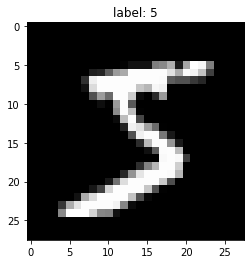

In [3]:
print('mnist_train len: ', len(mnist_train))
print('mnist_test len: ', len(mnist_test))

image, label = mnist_train.__getitem__(0)
print('image data shape: ', image.size())
print('label: ',label)

img = image.numpy()
plt.title("label: %d"%label)
plt.imshow(img[0], cmap='gray')
plt.show()

5
torch.Size([1, 28, 28])
5


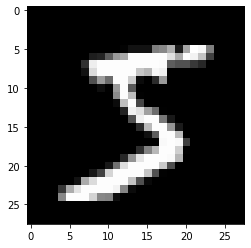

0


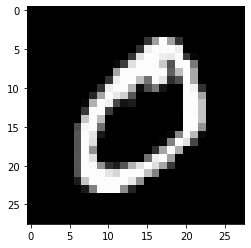

4


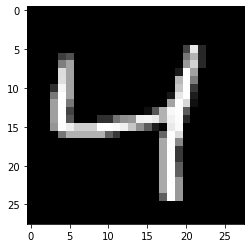

In [4]:
print(mnist_train[0][1])
print(mnist_train[0][0].size())

for i in range(3):
  img = mnist_train[i][0].numpy()
  print(mnist_train[i][1])
  plt.imshow(img[0],cmap='gray')
  plt.show()

torch.Size([1, 1, 28, 28])
5
torch.Size([1, 3, 28, 28])


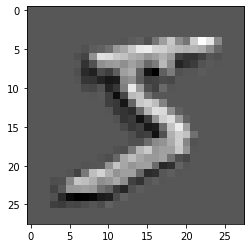

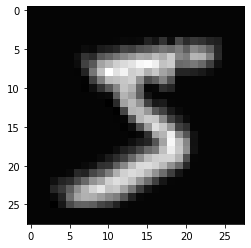

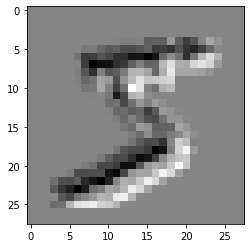

In [5]:
image, label = mnist_train[0]

image = image.view(-1,image.size()[0],image.size()[1],image.size()[2])
print(image.size())
print(label)

conv_layer = nn.Conv2d(in_channels=1,out_channels=3,kernel_size=3,padding=1)

output = conv_layer(Variable(image))
print(output.size())

for i in range(3):
  plt.imshow(output[0,i,:,:].data.numpy(), cmap='gray')
  plt.show()

In [6]:
def ComputeAccr(dloader, imodel):
  correct = 0
  total = 0
    
  with torch.no_grad():
    for j, [imgs, labels] in enumerate(dloader):
      img = Variable(imgs).cuda()
      label = Variable(labels).cuda()

      output = imodel.forward(img)
      _, output_index = torch.max(output, 1)
        
      total += label.size(0)
      correct += (output_index == label).sum().float()
  print("Accuracy of Test Data: {}".format(100*correct/total))
  return 100*correct/total  

# CNN 만들기
train, test data 가져오기

In [7]:
# hyper parameter
batch_size = 16
learning_rate = 2e-4
num_epoch = 10

In [8]:
train_loader = torch.utils.data.DataLoader(list(mnist_train)[:batch_size*100], batch_size=batch_size,
                                           shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader((mnist_test), batch_size=batch_size,
                                           shuffle=False, num_workers=2, drop_last=True)

In [9]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(1,16,5,padding=2),
        nn.ReLU(),

        nn.Conv2d(16,32,5,padding=2),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(32,64,5,padding=2),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    self.fc_layer = nn.Sequential(
        nn.Linear(64*7*7,100),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(100,10)
    )
  def forward(self, x):
    out = self.layer(x)
    out = out.view(batch_size,-1)
    out = self.fc_layer(out)
    out = nn.functional.log_softmax(out, dim=1)
    return out

model = CNN().cuda()

In [10]:
# 파라미터수 체크하기
# for parameter in model.parameters():
#   print(parameter)
#   print(parameter.shape)

In [11]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [12]:
train_acc = []
val_acc = []

#model = CNN().cuda()
Max=0
for i in range(num_epoch):
  model.train()
  print(str(i) + " epochs")
  for j, [image, label] in enumerate(train_loader):
    x=Variable(image).cuda()
    y_=Variable(label).cuda()
    
    optimizer.zero_grad() # grad가 누적합으로 계산되기 때문에 0으로 초기화
    output=model.forward(x) # 순방향 전파
    loss=loss_func(output,y_) # loss 계산
    loss.backward() # 역전파
    optimizer.step() 

  # model training 시각화를 위한 설정
  model.eval()
  tmp = ComputeAccr(test_loader,model)
  val_acc.append(tmp)
  train_acc.append(ComputeAccr(train_loader,model))
  print()

0 epochs
Accuracy of Test Data: 80.11000061035156
Accuracy of Test Data: 81.5

1 epochs
Accuracy of Test Data: 90.29999542236328
Accuracy of Test Data: 91.0625

2 epochs
Accuracy of Test Data: 91.61000061035156
Accuracy of Test Data: 94.0625

3 epochs
Accuracy of Test Data: 92.61000061035156
Accuracy of Test Data: 95.0625

4 epochs
Accuracy of Test Data: 93.94999694824219
Accuracy of Test Data: 96.5

5 epochs
Accuracy of Test Data: 94.57999420166016
Accuracy of Test Data: 97.625

6 epochs
Accuracy of Test Data: 93.43999481201172
Accuracy of Test Data: 96.9375

7 epochs
Accuracy of Test Data: 94.75999450683594
Accuracy of Test Data: 98.1875

8 epochs
Accuracy of Test Data: 95.04999542236328
Accuracy of Test Data: 99.1875

9 epochs
Accuracy of Test Data: 95.18999481201172
Accuracy of Test Data: 99.5625



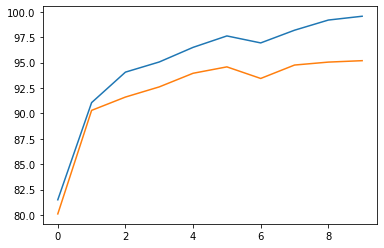

In [13]:
def plot_train(train_acc, val_acc):
  x = list(range(len(train_acc)))
  plt.plot(x, train_acc)
  plt.plot(x, val_acc)
  plt.show()

plot_train(train_acc, val_acc)

# 모델 저장

In [14]:
path ='/content/'
torch.save(model, path + 'my_cnn_model_%d.pkl'%(num_epoch))

In [15]:
try:
  model = torch.load(path+'my_cnn_model_%d.pkl'%(num_epoch))
  print('model restored')
except:
  print('model not restored')

model restored


In [16]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 95.18999481201172


tensor(95.1900, device='cuda:0')